# Introdução à Inteligência Artificial
## Classificação de Qualidade de Café

Aluna: Samantha Dantas Medeiros

Dataset: Coffee Quality from CQI, fish.csv @ [Kaggle](https://www.kaggle.com/datasets/volpatto/coffee-quality-database-from-cqi) 

**Objetivo**: classificar a qualidade do café (bom ou ruim) de acordo com base em suas características.

> Estarei utilizando a base de dados sobre o café do tipo *Arabico*

### Importação de bibliotecas

In [239]:
from statistics import mode

import pandas as pd
import seaborn as sns
import opendatasets as od
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix)

### Pré-processamento de Dados
O pré-processamento de dados é uma etapa fundamental na análise de dados e mineração de dados, pois visa preparar os dados para análise e modelagem.

In [240]:
df = pd.read_csv('./arabica_data_cleaned.csv', encoding='utf-8')

In [241]:
df.head() # exibe os 5 primeiros elementos do dataframe
df.columns # exibe as colunas do dataframe
df.describe() # para retornar um resumo estatístico das variáveis numéricas
df.info() # para dar um resumo de valores não nulos encontrados


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1311 non-null   int64  
 1   Species                1311 non-null   object 
 2   Owner                  1304 non-null   object 
 3   Country.of.Origin      1310 non-null   object 
 4   Farm.Name              955 non-null    object 
 5   Lot.Number             270 non-null    object 
 6   Mill                   1001 non-null   object 
 7   ICO.Number             1165 non-null   object 
 8   Company                1102 non-null   object 
 9   Altitude               1088 non-null   object 
 10  Region                 1254 non-null   object 
 11  Producer               1081 non-null   object 
 12  Number.of.Bags         1311 non-null   int64  
 13  Bag.Weight             1311 non-null   object 
 14  In.Country.Partner     1311 non-null   object 
 15  Harv

#### Lidando com Dados Ausentes
O tratamento de valores ausentes em uma base de dados é uma etapa importante do pré-processamento de dados, pois valores faltantes podem afetar negativamente a análise e os resultados.

Há duas formas de tratar dados ausentes:
* Exluir valores ausentes: `df.dropna(axis=0)`, esse método pode reduzir significativamente o tamanho da base de dados.
* Preencher valores ausentes: `df.fillna()` com `median()` ou `mode()`, depende do tipo de variável
  * Moda para variáveis categóricas
  * Mediana para variáveis numéricas contínuas

In [242]:
# Removendo colunas irrelevantes
df = df.drop(
  ['Species', # já que a base de dados é sobre essa espécies, não há necessidade de tê-la aqui
  'Producer',
  'Lot.Number',
  'ICO.Number',
  'Farm.Name', 
  'Company',
  'Owner', 
  'Owner.1',
  'Unnamed: 0', 
  'Mill', 
  'Number.of.Bags', 
  'Bag.Weight', 
  'In.Country.Partner', 
  'Harvest.Year', 
  'Grading.Date', 
  'Category.One.Defects', 
  'Quakers', 
  'Color', 
  'Category.Two.Defects', 
  'Expiration', 
  'Certification.Body', 
  'Certification.Address', 
  'Certification.Contact', 
  'unit_of_measurement',
  'altitude_low_meters',
  'altitude_high_meters',
  'altitude_mean_meters'
  ], 
axis=1)

In [243]:
df.isnull().sum() #para retornar a soma dos valores nulos encontrados

Country.of.Origin      1
Altitude             223
Region                57
Variety              201
Processing.Method    152
Aroma                  0
Flavor                 0
Aftertaste             0
Acidity                0
Body                   0
Balance                0
Uniformity             0
Clean.Cup              0
Sweetness              0
Cupper.Points          0
Total.Cup.Points       0
Moisture               0
dtype: int64

In [244]:

# Preenchendo coluna com valores nulos com moda, valores categóricos
df['Country.of.Origin'] = df['Country.of.Origin'].fillna(df['Country.of.Origin'].mode()[0]) 
df['Region'] = df['Region'].fillna(df['Region'].mode()[0])
df['Variety'] = df['Variety'].fillna(df['Variety'].mode()[0])
df['Processing.Method'] = df['Processing.Method'].fillna(df['Processing.Method'].mode()[0]) 

# Preenchendo colunas com valores nulos com mediana, valores contínuos
df['Altitude'] = df['Altitude'].str.extract(r'(\d+)').astype(float)
df['Altitude'] = df['Altitude'].fillna(df['Altitude'].median())

# Verificando valores nulos
df.isnull().sum() #para retornar a soma dos valores nulos encontrados

Country.of.Origin    0
Altitude             0
Region               0
Variety              0
Processing.Method    0
Aroma                0
Flavor               0
Aftertaste           0
Acidity              0
Body                 0
Balance              0
Uniformity           0
Clean.Cup            0
Sweetness            0
Cupper.Points        0
Total.Cup.Points     0
Moisture             0
dtype: int64

### Treinamento do Modelo
Para o seguinte modelo, são levado em conta todos os atributos numéricos, como nota de sabor, aroba e outros. 

Alguns dos valores qualitativos (ou não contínuos) desejados serão os alvos do modelo e receberão valores binários de acordo com o alvo.

In [245]:
df.columns

Index(['Country.of.Origin', 'Altitude', 'Region', 'Variety',
       'Processing.Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points', 'Moisture'],
      dtype='object')

In [253]:
# Fazendo cópia da base de dados original com as colunas desejadas

coffee_df = df.copy()

In [254]:
# Substituindo valores qualitativos das colunas com valores binários
coffee_df["Country.of.Origin"] = coffee_df["Country.of.Origin"].map(lambda x: 1 if x == "Mexico" else 0)
coffee_df["Variety"] = coffee_df["Variety"].map(lambda x: 1 if x == "Caturra" else 0)
coffee_df["Region"] = coffee_df["Region"].map(lambda x: 1 if x == "huila" else 0)
coffee_df["Processing.Method"] = coffee_df["Processing.Method"].map(lambda x: 1 if x == "Washed / Wet" else 0)


In [255]:
coffee_df.head()

,Country.of.Origin,Altitude,Region,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture
0,0,1950.0,0,1,1,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,90.58,0.12
1,0,1950.0,0,0,1,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12
2,0,1600.0,1,0,1,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,89.75,0.00
3,0,1800.0,0,1,0,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,89.00,0.11
4,0,1950.0,0,0,1,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83,0.12


In [256]:
print(coffee_df.dtypes)

Country.of.Origin      int64
Altitude             float64
Region                 int64
Variety                int64
Processing.Method      int64
Aroma                float64
Flavor               float64
Aftertaste           float64
Acidity              float64
Body                 float64
Balance              float64
Uniformity           float64
Clean.Cup            float64
Sweetness            float64
Cupper.Points        float64
Total.Cup.Points     float64
Moisture             float64
dtype: object


In [257]:
coffee_df.describe()

,Country.of.Origin,Altitude,Region,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.00000,1311.000000,1311.000000,1311.000000,1311.000000
mean,0.180778,1691.694127,0.128909,0.348589,0.735317,7.563806,7.518070,7.397696,7.533112,7.517727,7.517506,9.833394,9.83312,9.903272,7.497864,82.115927,0.088863
std,0.384981,5301.982877,0.335227,0.476705,0.441333,0.378666,0.399979,0.405119,0.381599,0.359213,0.406316,0.559343,0.77135,0.530832,0.474610,3.515761,0.047957
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1200.000000,0.000000,0.000000,0.000000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.000000,10.00000,10.000000,7.250000,81.170000,0.090000
50%,0.000000,1400.000000,0.000000,0.000000,1.000000,7.580000,7.580000,7.420000,7.500000,7.500000,7.500000,10.000000,10.00000,10.000000,7.500000,82.500000,0.110000
75%,0.000000,1600.000000,0.000000,1.000000,1.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.000000,10.00000,10.000000,7.750000,83.670000,0.120000
max,1.000000,190164.000000,1.000000,1.000000,1.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.000000,10.00000,10.000000,10.000000,90.580000,0.280000


#### Definição de atributos
Onde:
* x é a variável alvo 
* y1, y2, y3 e y4 são as variáveis independetes.

In [258]:
x = coffee_df.drop(['Variety','Country.of.Origin','Region','Processing.Method'], axis = 1)
y1 = coffee_df.loc[:, 'Variety']
y2 = coffee_df.loc[:, 'Country.of.Origin']
y3 = coffee_df.loc[:, 'Region']
y4 = coffee_df.loc[:, 'Processing.Method']

x = RobustScaler().fit_transform(x)

#### Separando dados de treinamento
Onde:
* test_size: É a proporção dos dados que serão usados para teste. Neste caso, 0.2 indica que 20% dos dados serão usados para teste e 80% serão usados para treinamento.
* random_state: É o valor usado como semente para o gerador de números aleatórios, que é usado na divisão dos dados em treinamento e teste. O uso de um valor fixo para `random_state` garante que a divisão dos dados será sempre a mesma, o que é importante para a reprodutibilidade dos resultados.

In [259]:
# Separando dados de treinamento e teste para y1 (Variety)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y1, test_size= 0.2, random_state = 1)

# Separando dados de treinamento e teste para y2 (Country of Origin)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y2, test_size= 0.2, random_state = 1)

# Separando dados de treinamento e teste para y3 (Region)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y3, test_size= 0.2, random_state = 1)

# Separando dados de treinamento e teste para y4 (Processing Method)
x_train4, x_test4, y_train4, y_test4 = train_test_split(x, y4, test_size= 0.2, random_state = 1)

### Correlação

In [260]:
# Definindo a lista de cores
colors = [
  '#4F0E0E',
  '#B05B3B',
  '#D79771',
  '#FFEBC9'
]

# Criando a paleta de cores
mypalette = mcolors.LinearSegmentedColormap.from_list('mypalette', colors)

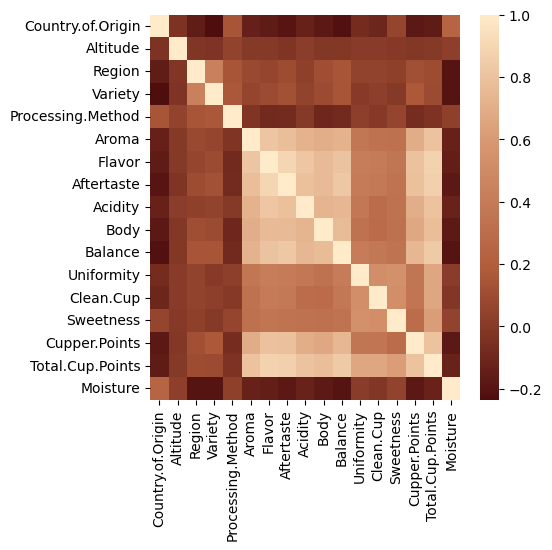

In [261]:
plt.figure(figsize = (5, 5))

sns.heatmap(coffee_df.corr(), cmap = mypalette);

### PCA

### KNN

In [265]:
k_list = [1,3,5,7,9]

knn_list = []

for k in k_list:
    knn_list.append(KNeighborsClassifier(n_neighbors = k))

for knn in knn_list:
    knn.fit(x_train1, y_train1)

In [268]:
result_list = []

for knn in knn_list:
    result_list.append(knn.predict(x_test1))

In [269]:
result_list

[array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       dtype=int64),
 array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0,

### Acurária

In [270]:
for result, k in zip(result_list, k_list):
    print(f'{k}-NN')
    print(f'Acurácia: {accuracy_score(y_test1, result):.5f}')

1-NN
Acurácia: 0.64639
3-NN
Acurácia: 0.67681
5-NN
Acurácia: 0.68441
7-NN
Acurácia: 0.68821
9-NN
Acurácia: 0.68821


### Precisão

In [272]:
for result, k in zip(result_list, k_list):
    print(f'{k}-NN')
    print(f'Precisão: {precision_score(y_test1, result):.5f}')

1-NN
Precisão: 0.47561
3-NN
Precisão: 0.52564
5-NN
Precisão: 0.54688
7-NN
Precisão: 0.56140
9-NN
Precisão: 0.56140


### Sensibilidade

In [273]:
for result, k in zip(result_list, k_list):
    print(f'{k}-NN')
    print(f'Sensibilidade: {recall_score(y_test1, result):.5f}')

1-NN
Sensibilidade: 0.43820
3-NN
Sensibilidade: 0.46067
5-NN
Sensibilidade: 0.39326
7-NN
Sensibilidade: 0.35955
9-NN
Sensibilidade: 0.35955


### Matriz Confusão

In [274]:
for result, k in zip(result_list, k_list):
    print(f"{k}-NN")
    print(confusion_matrix(y_test1, result))

1-NN
[[131  43]
 [ 50  39]]
3-NN
[[137  37]
 [ 48  41]]
5-NN
[[145  29]
 [ 54  35]]
7-NN
[[149  25]
 [ 57  32]]
9-NN
[[149  25]
 [ 57  32]]
